In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set random seed 
RSEED = 100

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 18

import seaborn as sns
palette = sns.color_palette('Paired', 10)

In [2]:
data = pd.read_csv('input/clean_data.csv')
test = pd.read_csv('input/clean_test.csv')

print('Data observations: ', data.shape[0])
print('Test observations: ', test.shape[0])
print('Number of features: ', test.shape[1])

Data observations:  4892738
Test observations:  9914
Number of features:  29


In [3]:
data = data[data['fare_amount'] >= 2.50]
data['fare_amount'].describe()

count   4892578.000
mean         11.278
std           9.365
min           2.500
25%           6.000
50%           8.500
75%          12.500
max         100.000
Name: fare_amount, dtype: float64

# Keras

### Take Log of Target Variable

A good rule when training neural networks is to take the log of the target. You can also scale the target to between 0 and 1.

In [4]:
y = np.array(data.pop('fare_amount'))
log_y = np.log(y)
max_log_y = log_y.max()

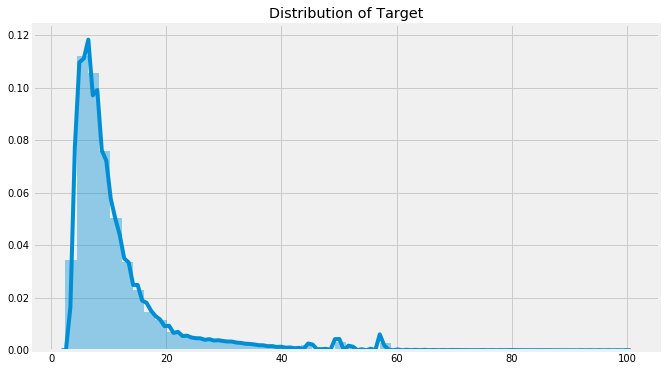

In [5]:
plt.figure(figsize = (10, 6))
sns.distplot(y);
plt.title("Distribution of Target");

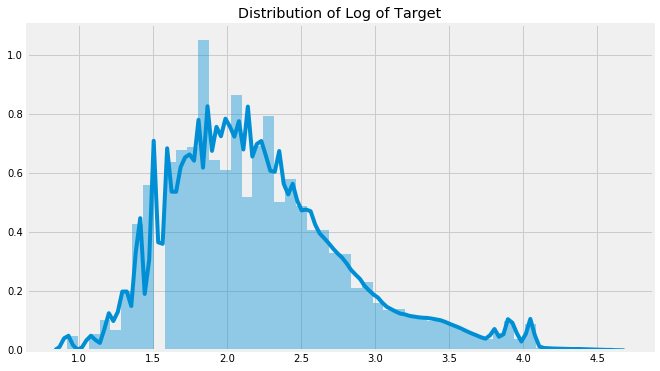

In [6]:
plt.figure(figsize = (10, 6))
sns.distplot(log_y);
plt.title("Distribution of Log of Target");

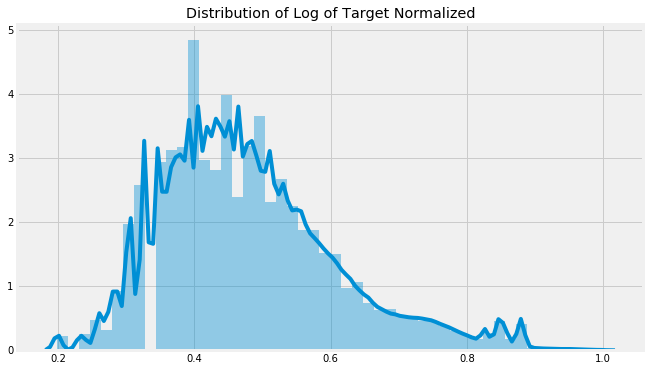

In [7]:
plt.figure(figsize = (10, 6))
sns.distplot(log_y / max_log_y);
plt.title("Distribution of Log of Target Normalized");

## Scale Features

Neural networks generally have more stable training when the features are normalized to between 0 and 1. Another common option is to subtract the mean and divide by the standard deviation, known as standardization. However, I find normalizing to between 0 and 1 to be a safer option.

In [8]:
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare-bin,abs_lat_diff,abs_lon_diff,manhattan,euclidean,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration
0,-73.844,40.721,-73.842,40.712,1,"(0, 5]",0.009,0.003,0.012,0.009,...,26,21,365,0.727,0.104,0.507,0.456,14318735.000,2.700,6.000
1,-74.016,40.711,-73.979,40.782,1,"(15, 20]",0.071,0.037,0.107,0.080,...,52,16,365,0.703,0.243,0.178,0.016,31942290.000,8.900,28.000
2,-73.983,40.761,-73.991,40.751,2,"(05, 10]",0.011,0.009,0.019,0.014,...,35,0,365,0.024,0.432,0.563,0.628,82859654.000,2.400,13.000
3,-73.987,40.733,-73.992,40.758,1,"(05, 10]",0.025,0.004,0.029,0.025,...,30,42,366,0.188,0.741,0.683,0.306,104214596.000,4.500,21.000
4,-73.968,40.768,-73.957,40.784,1,"(05, 10]",0.016,0.011,0.027,0.019,...,51,0,365,0.327,0.190,0.291,0.187,37353014.000,2.300,9.000


In [9]:
from sklearn.preprocessing import MinMaxScaler

features = list(data.drop(columns = ['fare-bin']).columns)

# Fit on training data and scale test data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.drop(columns = ['fare-bin']))
scaled_test = scaler.transform(test.drop(columns = ['fare-bin']))

## Create Stratified Validation Set 

We'll create a separate set for validating our model. When we split the data, we'll stratify it by the binned fare amount in order to have the same distribution of the target in both the training and validation data.

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(scaled_data, log_y, random_state = RSEED,
                                                      test_size = 1_000_000)

In [12]:
print('Length of training: ', X_train.shape[0])
print('Length of testing:  ', X_valid.shape[0])

Length of training:  3892578
Length of testing:   1000000


# Putting Together the Model

Our model will be a dense, fully-connected deep neural network. We will build it using the `Sequential` API. The `Sequential` framework allows us to build a model by adding one layer at a time. (The other option is the `Functional` framework which allows greater control over the model at the cost of increased building time. For the differences refer to [this article](https://jovianlin.io/keras-models-sequential-vs-functional/)).

In [13]:
from keras import layers, models, optimizers, losses, metrics
from keras import backend as K

Using TensorFlow backend.


### Build Model

Building a deep neural network in Keras is pleasantly simple. Using the Sequential API, we can add one layer at a time. For each layer, we need to specify:

* The number of neurons
* The activation function

The first layer must also have an `input_shape` or an `input_dim` which in this case is the number of features in our data. 

The final layer has no activation function because it provides the final estimate.

#### Dense Layers

All the layers are dense, indicating that the inputs are connected to every neuron in the layer. This means that each neuron has one weight for every input. A dense network is the only way to handle stuctured data (at the moment).

#### Dropout

Dropout is an effective technique for regularizing a neural network (preventing overfitting). It randomly sets the weights of a fraction of the neurons to 0 for each training batch. The reason this works is because it builds resiliency into the network. We'll use a dropout layer after each Dense layers

In [14]:
model = models.Sequential()

# Input layer
model.add(layers.Dense(16, input_dim = scaled_data.shape[1], activation = 'relu', name = 'input'))
model.add(layers.Dropout(0.5))

# Hidden layers
model.add(layers.Dense(32, activation = 'relu', name = 'hidden-1'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(64, activation = 'relu', name = 'hidden-2'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(128, activation = 'relu', name = 'hidden-3'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation = 'relu', name = 'hidden-4'))
model.add(layers.Dropout(0.5))

# Prediction layer
model.add(layers.Dense(1, activation = None, name = 'output'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (Dense)                (None, 16)                480       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
hidden-1 (Dense)             (None, 32)                544       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
hidden-2 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
hidden-3 (Dense)             (None, 128)               8320      
__________

## Custom Scoring Function

Keras does not offer the root mean squared error as one of the scoring functions. Instead, we can write our own custom scoring function to calculate the rmse. I've found that training with a custom scoring metric can be unstable, so we'll actually train with the `mean_squared_error` on the log of the targets. We'll use our custom functions to put the score in a range that we can use for comparison.

The first function calculates the root of the mean squared error. The second function converts the predictions and the true values back to the original range. The exponentiation undoes the logarithm to put the values back on the original scale.

In [15]:
# Root mean squared error calculation
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1)) 

# Get the predictions back on original scale
def convert_error(y_true, y_pred):
    return root_mean_squared_error(K.exp(y_true), K.exp(y_pred))

## Compile Model

To compile a model, we need two parts:

1. An optimizer: the method used for adjusting the weights on each batch
2. A loss: the measure of the model's error that is minimized by the optimization procedure

To monitor performance, we'll addd in out custom metric.

In [16]:
model.compile(optimizer = optimizers.Adam(),
              loss = losses.mean_squared_error,
              metrics = [convert_error])

## Model Callbacks 

Model callbacks control aspects of training and allow us to diagnose a model. Here we'll use three callbacks:

1. Early stopping: stop training when the validation loss has not improved for a specified number of epochs
    * Meant to serve as a method to avoid overfitting
2. Model checkpointing: every time the validation loss decreases, save a copy of the model. 
    * Allows us to load the best model back in for making predictions
3. Tensorboard monitoring: training results are saved to a directory that we can visualize with Tensorboard
    * Tensorboard is useful for diagnosing the progress of a model
    
If you are running on a local machine, Tensorboard can be used to visualize results in real time. If not, then we can use the saved Tensorboard results to examine the performance after the training run.

In [17]:
from datetime import datetime
'_'.join(str(datetime.now())[:-7].split())

'2018-09-07_16:48:17'

In [18]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

calls = [EarlyStopping(monitor = 'val_loss', patience = 3),
         ModelCheckpoint(filepath = f'./checkpoints/{"_".join(str(datetime.now())[:-7].split())}.ckpt', 
                         save_best_only = True, save_weights_only = True),
         TensorBoard(log_dir = './logs/')]

## Train Model

The model is now ready to be trained. The primary decision we have to make is the batch size. A larger batch size means faster training, but it can also detrimentally affect model performance. It's good practice to experiment with several different batch sizes.

In [19]:
model.fit(X_train, y_train, batch_size = 1024, epochs = 50, verbose = 1,
          callbacks = calls, validation_data = (X_valid, y_valid))

Train on 3892578 samples, validate on 1000000 samples
Epoch 1/50
3892578/3892578 [==============================] - 29s 8us/step - loss: 0.1855 - convert_error: 25.0265 - val_loss: 0.2738 - val_convert_error: 4.7656
Epoch 2/50
3892578/3892578 [==============================] - 29s 7us/step - loss: 0.1035 - convert_error: 2.7105 - val_loss: 0.2390 - val_convert_error: 4.5110
Epoch 3/50
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.0957 - convert_error: 2.5815 - val_loss: 0.2316 - val_convert_error: 4.4520
Epoch 4/50
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.0926 - convert_error: 2.5121 - val_loss: 0.2238 - val_convert_error: 4.3813
Epoch 5/50
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.0909 - convert_error: 2.4663 - val_loss: 0.2194 - val_convert_error: 4.3872
Epoch 6/50
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.0899 - convert_error: 2.4390 - val_loss: 0.2149 - val_c

In [20]:
# model.load_weights('./checkpoints/2018-09-07_16:07:02.ckpt')
valid_log_predictions = model.predict(X_valid).reshape((-1))
valid_predictions = np.exp(valid_log_predictions)

rmse = np.sqrt(np.mean(np.square(valid_predictions - np.exp(y_valid))))
mape = 100 * np.mean(abs(valid_predictions - np.exp(y_valid)) / np.exp(y_valid))
print(f'Validation rmse = {round(rmse, 3)}')
print(f'Validation mape = {round(mape, 3)}')

Validation rmse = 8.568
Validation mape = 27.304


In [21]:
model.evaluate(X_valid, y_valid)

1000000/1000000 [==============================] - 34s 34us/step


[0.21429088801717758, 4.33443515140152]

In [22]:
data.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,abs_lat_diff,abs_lon_diff,manhattan,euclidean,haversine,...,pickup_Minute,pickup_Second,pickup_Days_in_year,pickup_frac_day,pickup_frac_week,pickup_frac_month,pickup_frac_year,pickup_Elapsed,distance,duration
0,-73.844,40.721,-73.842,40.712,1,0.009,0.003,0.012,0.009,1.032,...,26,21,365,0.727,0.104,0.507,0.456,14318735.000,2.700,6.000
1,-74.016,40.711,-73.979,40.782,1,0.071,0.037,0.107,0.080,8.459,...,52,16,365,0.703,0.243,0.178,0.016,31942290.000,8.900,28.000
2,-73.983,40.761,-73.991,40.751,2,0.011,0.009,0.019,0.014,1.391,...,35,0,365,0.024,0.432,0.563,0.628,82859654.000,2.400,13.000
3,-73.987,40.733,-73.992,40.758,1,0.025,0.004,0.029,0.025,2.802,...,30,42,366,0.188,0.741,0.683,0.306,104214596.000,4.500,21.000
4,-73.968,40.768,-73.957,40.784,1,0.016,0.011,0.027,0.019,2.001,...,51,0,365,0.327,0.190,0.291,0.187,37353014.000,2.300,9.000


In [23]:
data.columns

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'abs_lat_diff', 'abs_lon_diff',
       'manhattan', 'euclidean', 'haversine', 'pickup_Year', 'pickup_Month',
       'pickup_Week', 'pickup_Day', 'pickup_Dayofweek', 'pickup_Dayofyear',
       'pickup_Days_in_month', 'pickup_is_leap_year', 'pickup_Hour',
       'pickup_Minute', 'pickup_Second', 'pickup_Days_in_year',
       'pickup_frac_day', 'pickup_frac_week', 'pickup_frac_month',
       'pickup_frac_year', 'pickup_Elapsed', 'distance', 'duration'],
      dtype='object')

In [24]:
to_keep = ['abs_lat_diff', 'abs_lon_diff','haversine', 'pickup_frac_day', 
           'pickup_frac_week', 'pickup_frac_month', 'pickup_frac_year', 'duration']

In [25]:
scaled_data = scaler.fit_transform(data[to_keep])
scaled_test = scaler.transform(test[to_keep])

In [26]:
X_train, X_valid, y_train, y_valid = train_test_split(scaled_data, log_y, random_state = RSEED,
                                                      test_size = 1_000_000)

In [30]:
def get_model():
    model = models.Sequential()

    # Input layer
    model.add(layers.Dense(16, input_dim = scaled_data.shape[1], activation = 'relu', name = 'input'))
    model.add(layers.Dropout(0.5))

    # Hidden layers
    model.add(layers.Dense(32, activation = 'relu', name = 'hidden-1'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(64, activation = 'relu', name = 'hidden-2'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation = 'relu', name = 'hidden-3'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, activation = 'relu', name = 'hidden-4'))
    model.add(layers.Dropout(0.5))

    # Prediction layer
    model.add(layers.Dense(1, activation = None, name = 'output'))

    calls = [EarlyStopping(monitor = 'val_loss', patience = 3),
             ModelCheckpoint(filepath = f'./checkpoints/{"_".join(str(datetime.now())[:-7].split())}.ckpt', 
                             save_best_only = True, save_weights_only = True),
             TensorBoard(log_dir = './logs/')]
    
    model.compile(optimizer = optimizers.Adam(),
                  loss = losses.mean_squared_error,
                  metrics = [convert_error])
    
    return model, calls

In [31]:
model, calls = get_model()

In [32]:
model.fit(X_train, y_train, batch_size = 1024, epochs =  10, 
          callbacks = calls, validation_data = (X_valid, y_valid))

Train on 3892578 samples, validate on 1000000 samples
Epoch 1/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1957 - convert_error: 14.9171 - val_loss: 0.1593 - val_convert_error: 3.7327
Epoch 2/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1125 - convert_error: 2.8421 - val_loss: 0.1562 - val_convert_error: 3.7104
Epoch 3/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1049 - convert_error: 2.7009 - val_loss: 0.1550 - val_convert_error: 3.7020
Epoch 4/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1017 - convert_error: 2.6309 - val_loss: 0.1564 - val_convert_error: 3.6994
Epoch 5/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1002 - convert_error: 2.5963 - val_loss: 0.1552 - val_convert_error: 3.7101
Epoch 6/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.0996 - convert_error: 2.5818 - val_loss: 0.1610 - val_c

In [34]:
model.load_weights('checkpoints/2018-09-07_18:10:33.ckpt')
model.evaluate(X_valid, y_valid)

1000000/1000000 [==============================] - 35s 35us/step


[0.15499317616319655, 3.7019710661811827]

In [35]:
to_keep = ['haversine', 'pickup_frac_day', 'pickup_frac_week', 
           'pickup_frac_month', 'pickup_frac_year', 'duration']

scaled_data = scaler.fit_transform(data[to_keep])
scaled_test = scaler.transform(test[to_keep])

X_train, X_valid, y_train, y_valid = train_test_split(scaled_data, log_y, random_state = RSEED,
                                                      test_size = 1_000_000)

In [36]:
model, calls = get_model()
model.fit(X_train, y_train, batch_size = 1024, epochs =  10, 
          callbacks = calls, validation_data = (X_valid, y_valid))

Train on 3892578 samples, validate on 1000000 samples
Epoch 1/10
3892578/3892578 [==============================] - 29s 7us/step - loss: 0.2080 - convert_error: 4.0948 - val_loss: 0.2229 - val_convert_error: 4.3237
Epoch 2/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1123 - convert_error: 2.8497 - val_loss: 0.2057 - val_convert_error: 4.1728
Epoch 3/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1054 - convert_error: 2.7197 - val_loss: 0.1943 - val_convert_error: 4.0693
Epoch 4/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1026 - convert_error: 2.6587 - val_loss: 0.1918 - val_convert_error: 4.0655
Epoch 5/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1012 - convert_error: 2.6291 - val_loss: 0.1874 - val_convert_error: 4.0199
Epoch 6/10
3892578/3892578 [==============================] - 28s 7us/step - loss: 0.1008 - convert_error: 2.6166 - val_loss: 0.1981 - val_co

In [ ]:
rmse = np.sqrt(np.mean(np.square(valid_log_predictions - y_valid)))
rmse

In [ ]:
sns.distplot(valid_log_predictions)

In [ ]:
valid = np.exp(y_valid)
sns.distplot(valid)

In [ ]:
sns.distplot(np.exp(y_train))

In [ ]:
sns.distplot(valid_predictions)

In [ ]:
np.mean(np.square(valid_predictions - np.exp(y_valid)))

In [ ]:
sns.distplot(valid_log_predictions)

In [ ]:
sns.distplot(valid_predictions)

In [ ]:
rmse = np.sqrt(np.mean(np.square(valid_predictions - y_valid)))
rmse

In [ ]:
y_valid

In [ ]:
valid_predictions.reshape((-1)) - y_valid